In [98]:
%matplotlib inline

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')


In [100]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [101]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-08-13,0,0,0,0,0,שלילי,No,זכר,Other
1,2020-08-13,1,1,0,0,0,שלילי,No,נקבה,Abroad
2,2020-08-13,1,0,0,0,0,שלילי,No,זכר,Abroad
3,2020-08-13,0,0,0,0,0,חיובי,No,זכר,Other
4,2020-08-13,0,0,0,0,0,חיובי,Yes,זכר,Other


In [102]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [103]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [104]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [105]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,No,NaT
1,2020-03-18,2020-03-18,חיובי,1,No,NaT
2,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
3,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
4,2020-03-20,2020-03-20,שלילי,4,Yes,NaT


In [106]:
bdi.shape

(2045377, 6)

In [107]:
bdi.corona_result.value_counts()

שלילי               1876523
חיובי                130065
לא בוצע/פסול 999      21290
חיובי גבולי           16491
בעבודה                  610
לא ודאי                 398
Name: corona_result, dtype: int64

In [108]:
niv.corona_result.value_counts()

שלילי    1221552
חיובי      74778
אחר        16625
Name: corona_result, dtype: int64

In [109]:
niv.test_indication.value_counts()

Other                     1234391
Contact with confirmed      52111
Abroad                      26453
Name: test_indication, dtype: int64

In [110]:
niv.age_60_and_above.value_counts()

No     714283
Yes    107911
Name: age_60_and_above, dtype: int64

In [111]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [112]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [113]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [114]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [115]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,6,6,17,12.833333,13,12
1,3,11061,2,112,16.665582,17,33183
2,4,5081,2,114,21.462114,21,20324
3,5,3127,2,106,24.647905,25,15635
4,6,1786,6,96,27.668533,27,10716
5,7,1063,8,108,30.398871,30,7441
6,8,597,3,103,33.475712,33,4776
7,9,357,3,78,35.700280,35,3213
8,10,573,5,106,41.130890,41,5730


In [116]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

,index,total_tests_count
0,size,23651.000000
1,min,2.000000
2,max,12.000000
3,mean,4.320156
4,median,4.000000


In [117]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
9432,114,4,60+,זכר,Other
12342,112,3,30-39,זכר,Contact with confirmed
9304,111,4,20-29,זכר,Other
1600,108,7,40-49,נקבה,Contact with confirmed
6311,106,5,30-39,זכר,Contact with confirmed
23175,106,10+,0-19,נקבה,Contact with confirmed
9696,105,4,30-39,נקבה,Other
456,103,8,50-59,נקבה,Contact with confirmed
20936,103,3,0-19,זכר,Abroad
23273,100,10+,60+,זכר,Contact with confirmed


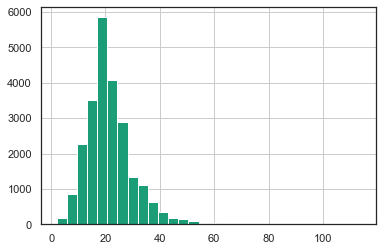

In [118]:
rec.days_between_pos_and_neg.hist(bins=30)

In [119]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-08-12,42284,11838,5265,840
1,2020-08-11,42217,11824,5708,957
2,2020-08-10,42159,11650,4994,1291
3,2020-08-09,42570,11008,3179,894
4,2020-08-08,42177,10512,3288,442


In [120]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [121]:
niv.age_60_and_above.value_counts()

No     714283
Yes    107911
Name: age_60_and_above, dtype: int64

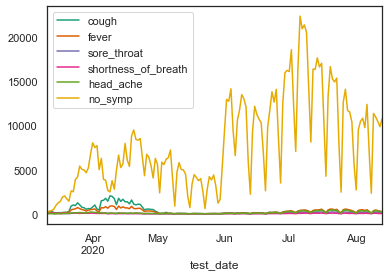

In [122]:
niv.groupby('test_date')[symptom_cols].sum().plot()

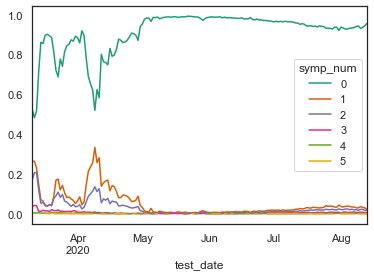

In [123]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

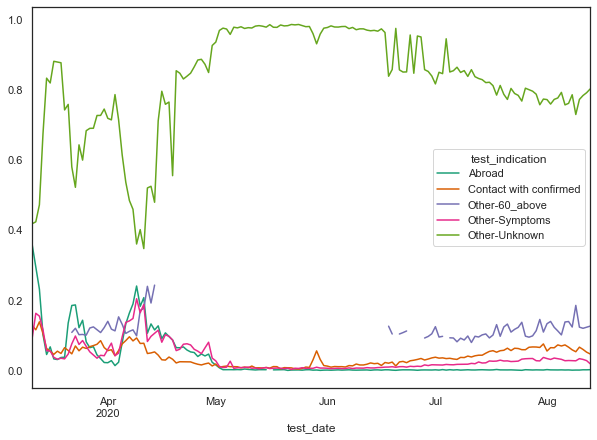

In [124]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

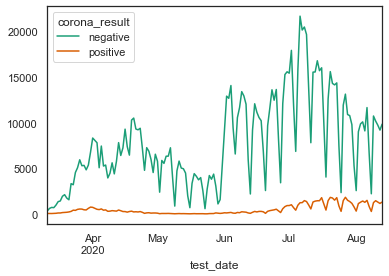

In [125]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [126]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

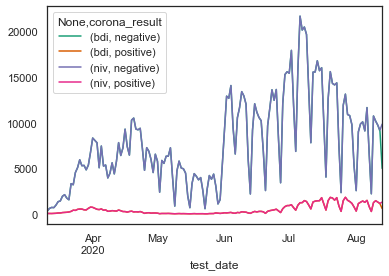

In [127]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

In [128]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1)

bdi               niv         
corona_result negative positive negative positive
test_date                                        
2020-03-11         320       43      320       42
2020-03-12         596       38      596       38
2020-03-13         704       36      704       36
2020-03-14         679       47      679       47
2020-03-15         956       61      956       61
...                ...      ...      ...      ...
2020-08-09       10730     1231    10730     1231
2020-08-10       10175     1440    10175     1440
2020-08-11        9723     1290     9726     1290
2020-08-12        9057     1107     9184     1142
2020-08-13        4979      581     9837     1292

[156 rows x 4 columns]

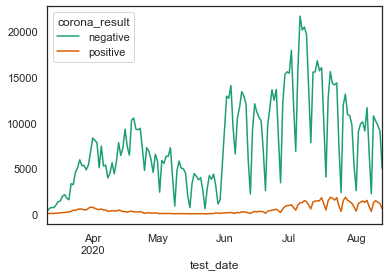

In [129]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [130]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,3,3
2020-03-12,21,9
2020-03-13,19,5
2020-03-14,27,5
2020-03-15,74,50
...,...,...
2020-08-09,11059,710
2020-08-10,12248,779
2020-08-11,12256,744


In [131]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,36.0,NaN,2375.0,18.0,NaN
2020-05-08,27.0,NaN,3945.0,18.0,NaN
2020-05-09,31.0,NaN,849.0,9.0,NaN
2020-05-12,46.0,NaN,5021.0,19.0,NaN
2020-05-14,60.0,1.0,4469.0,16.0,NaN
2020-05-15,28.0,NaN,1979.0,7.0,NaN
2020-05-16,24.0,NaN,675.0,4.0,NaN
2020-05-17,59.0,NaN,3341.0,15.0,NaN
2020-05-19,32.0,NaN,4120.0,12.0,NaN


In [132]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-08-09,92.0,NaN,10730.0,1231.0,NaN
2020-08-10,160.0,1.0,10175.0,1440.0,NaN
2020-08-11,156.0,NaN,9723.0,1290.0,NaN
2020-08-12,100.0,NaN,9057.0,1107.0,NaN
2020-08-13,82.0,NaN,4979.0,581.0,NaN


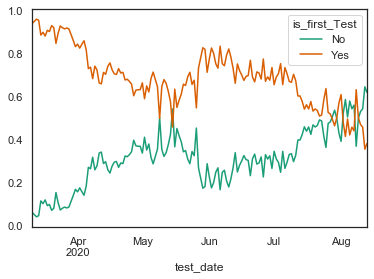

In [133]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

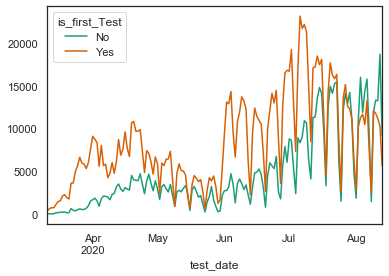

In [134]:
ti.plot()

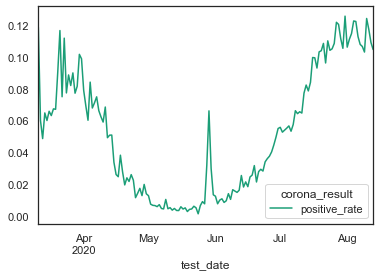

In [135]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [136]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-08-09,11975,12053
2020-08-10,13302,11776
2020-08-11,13255,11169
2020-08-12,18686,10264
2020-08-13,9158,5642


In [137]:
ti.Yes.sum() + ti.No.sum()

2045377

In [192]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [139]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [140]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [141]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&
          (bdi.corona_result.isin(['positive', 'negative'])) 
          ]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [142]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [143]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,75,36.0,48.0,17.4,15,20.0,63.0,15.3,68,...,47.0,16.8,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,97,39.2,50.0,18.0,15,20.0,63.0,15.3,90,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,115,39.1,49.0,18.0,15,20.0,63.0,15.3,105,...,47.0,17.4,15,50.0,64.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,153,41.2,47.0,18.3,15,0.0,70.0,7.4,144,...,46.0,17.5,15,50.0,64.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,192,44.3,47.0,18.6,15,20.0,74.0,7.6,178,...,45.0,17.6,15,50.0,58.0,14.9,15,37.5,79.0,9.1


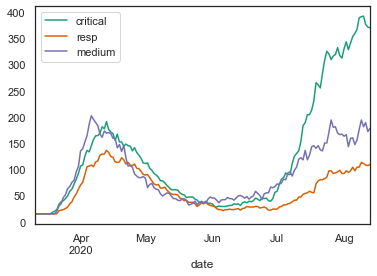

In [144]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [145]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,323,46,0.124661
1,2020-03-12,15,15,15,617,47,0.070783
2,2020-03-13,15,15,15,723,41,0.053665
3,2020-03-14,15,15,15,706,52,0.068602
4,2020-03-15,15,15,15,1030,111,0.097283


In [146]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [147]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


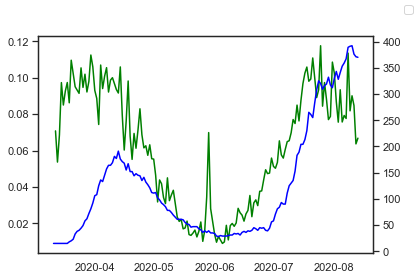

In [148]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [149]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [150]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [151]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

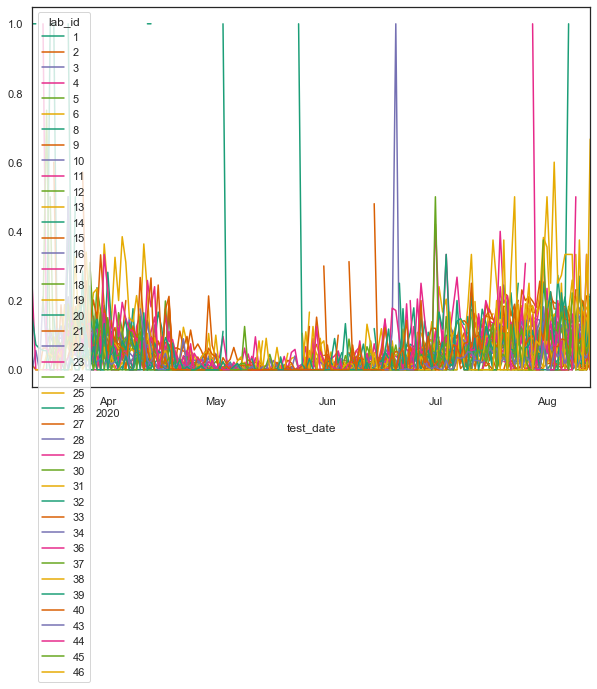

In [152]:
polab = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative)
polab.positive_rate.unstack().plot(figsize=(10,7))

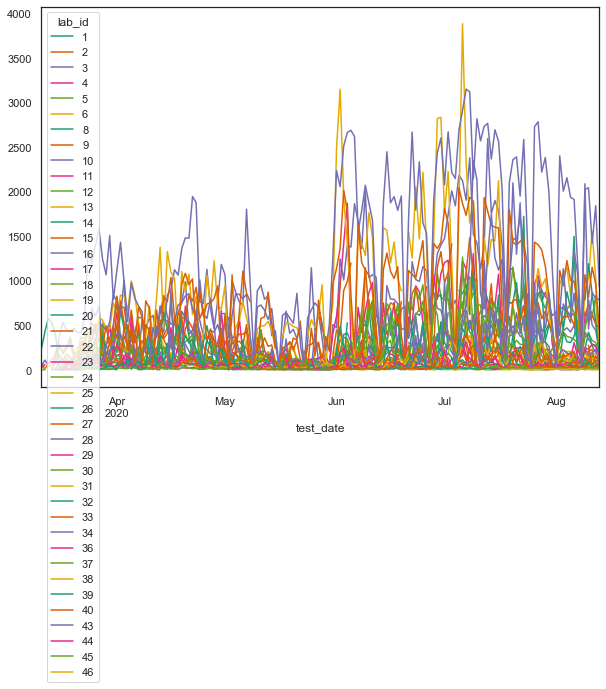

In [153]:
polab.total_tests.unstack().plot(figsize=(10,7))

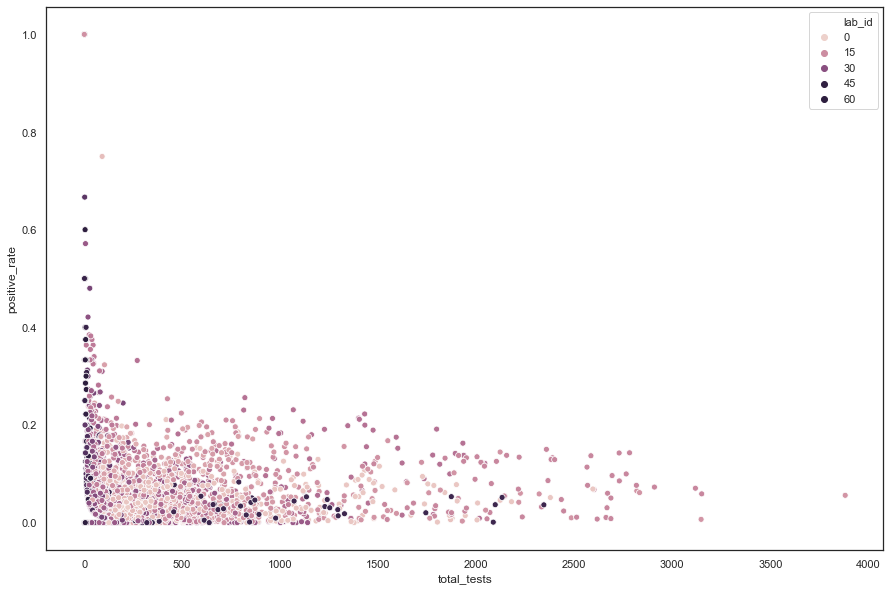

In [154]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [155]:
import altair as alt

In [156]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [157]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result,positive,negative,total_tests,positive_rate
lab_id,,,,
16,12467.0,174337.0,187353.0,3.6
3,6128.0,129228.0,136538.0,2.4
13,7925.0,118197.0,129521.0,3.4
21,10643.0,95096.0,106411.0,5.6
4,2988.0,63383.0,67143.0,2.4
10,3676.0,58670.0,64003.0,3.1
15,5344.0,55315.0,61379.0,4.8
12,3368.0,49560.0,53876.0,3.4
14,2413.0,47144.0,49924.0,2.6


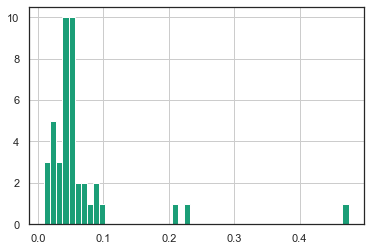

In [158]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [159]:
top_5_labs = bdi[bdi.is_first_Test=='Yes'].lab_id.value_counts().index[:5]
top_5_labs

Int64Index([16, 3, 13, 21, 4], dtype='int64')

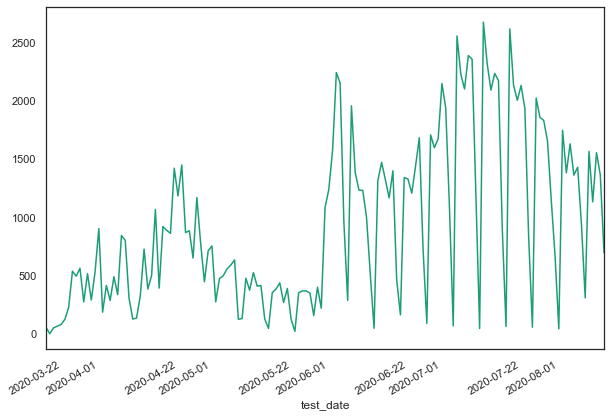

In [160]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

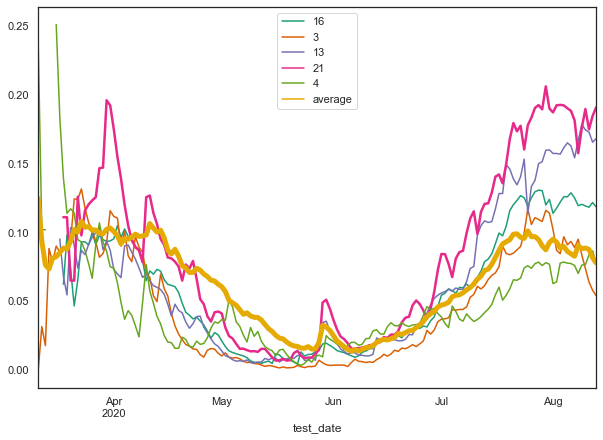

In [161]:
sns.set_palette(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=[1.5,1.5,1.5,2.5,1.5,5][i])


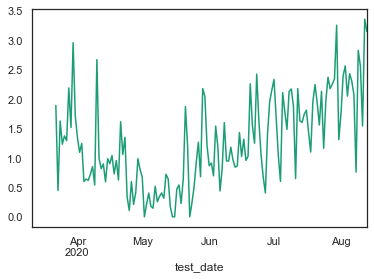

In [162]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [163]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06758460665197663

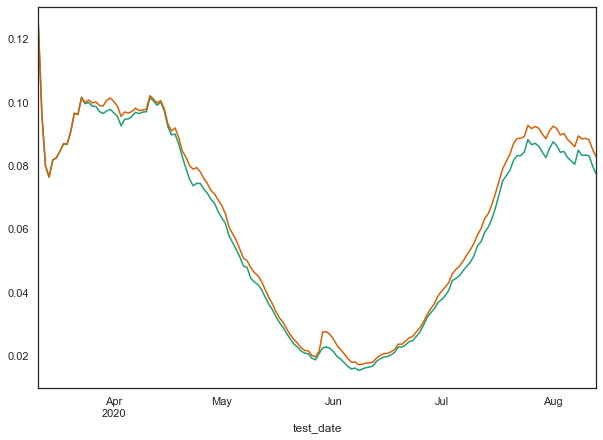

In [164]:
ax = (bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

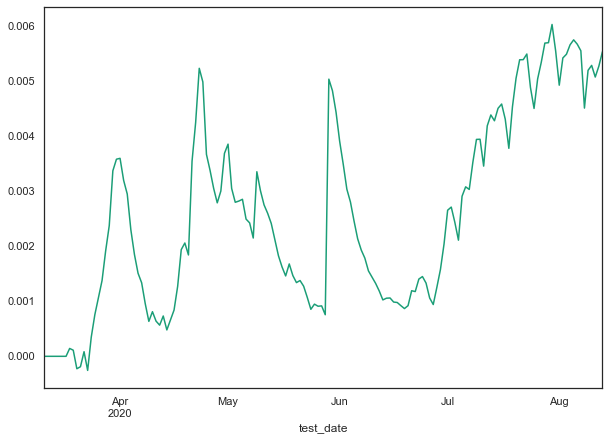

In [165]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

## Decseased 

In [166]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11)
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 1.0]    0.117005
(1.0, 3.0]       0.073323
(3.0, 5.0]       0.104524
(5.0, 7.0]       0.110764
(7.0, 8.0]       0.048362
(8.0, 10.0]      0.110764
(10.0, 12.0]     0.070203
(12.0, 16.0]     0.088924
(16.0, 21.0]     0.095164
(21.0, 29.0]     0.084243
(29.0, 107.0]    0.084243
Name: qc, dtype: float64

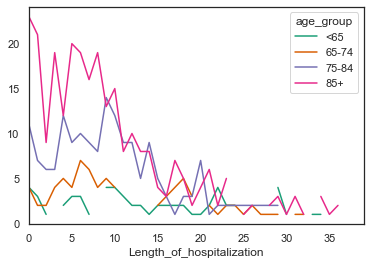

In [167]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

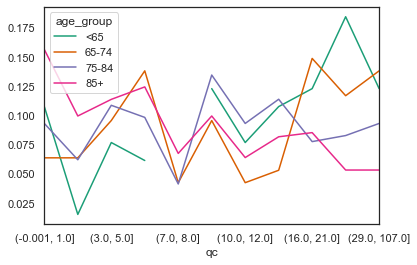

In [168]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [169]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.065523
1.0    0.051482
2.0    0.028081
3.0    0.045242
4.0    0.048362
5.0    0.056162
6.0    0.060842
7.0    0.049922
8.0    0.048362
9.0    0.056162
Name: Length_of_hospitalization, dtype: float64

In [170]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-36.0    0.00156
-21.0    0.00156
-15.0    0.00156
-14.0    0.00156
-12.0    0.00156
-9.0     0.00156
-8.0     0.00156
-6.0     0.00156
-5.0     0.00156
-4.0     0.00780
Name: Time_between_positive_and_hospitalization, dtype: float64

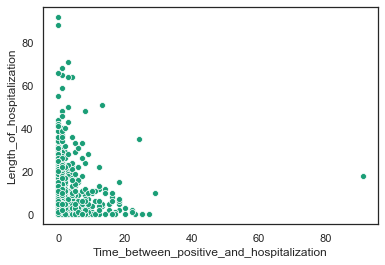

In [171]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

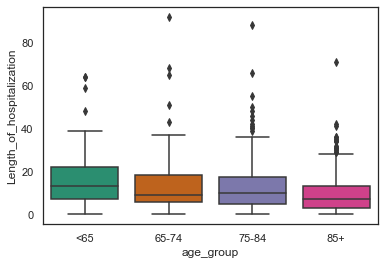

In [172]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [173]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

,gender,age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death,time,file
0,זכר,<65,1.0,2.0,20.0,22,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
203,נקבה,75-84,1.0,0.0,12.0,12,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
202,נקבה,85+,0.0,10.0,1.0,11,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
201,נקבה,85+,0.0,2.0,17.0,19,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
200,זכר,85+,1.0,0.0,9.0,9,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz


In [174]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((7421, 8), (557, 8))

In [175]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

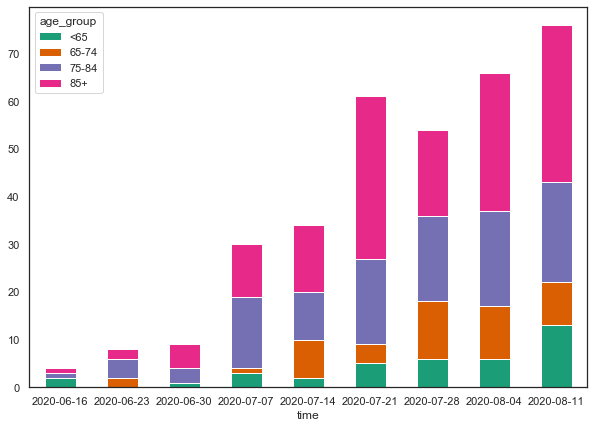

In [176]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

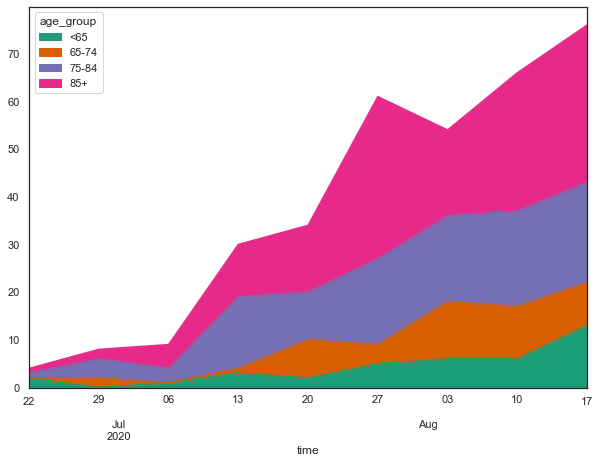

In [177]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

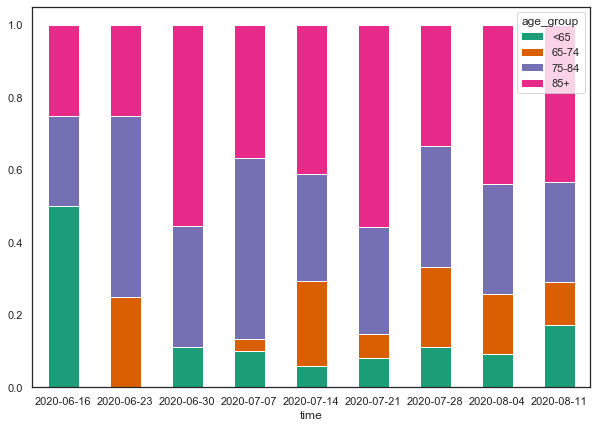

In [178]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [179]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


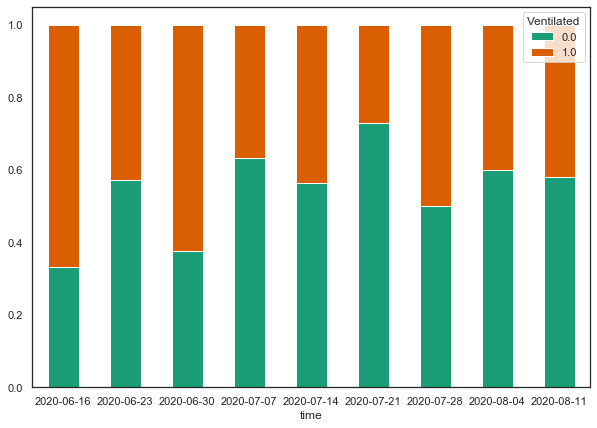

In [180]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

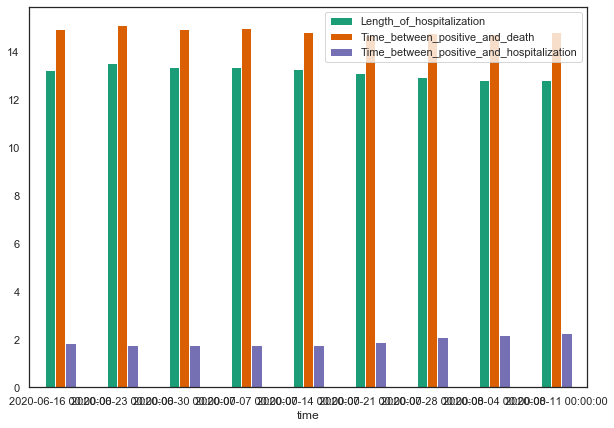

In [181]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


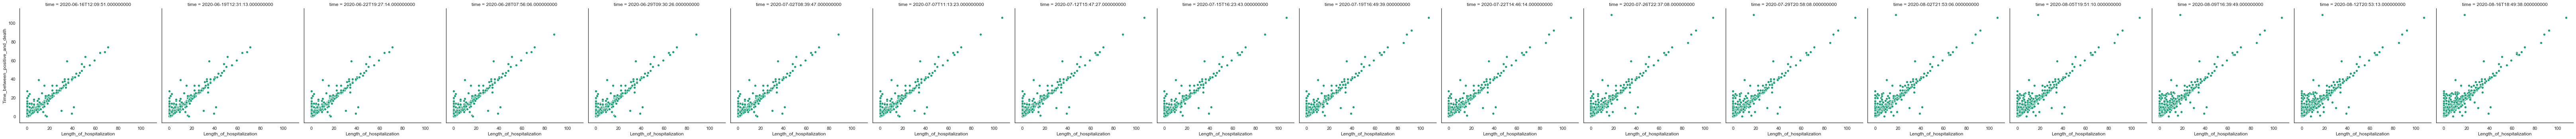

In [182]:
sns.relplot(data=decs, col='time', x='Length_of_hospitalization', y='Time_between_positive_and_death', kind='scatter')

In [183]:
hos.head().T

,0,1,2,3,4
date,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00
מאושפזים,75,97,115,153,192
אחוז נשים מאושפזות,36,39.2,39.1,41.2,44.3
גיל ממוצע מאושפזים,48,50,49,47,47
סטיית תקן גיל מאושפזים,17.4,18,18,18.3,18.6
resp,15,15,15,15,15
אחוז נשים מונשמות,20,20,20,0,20
גיל ממוצע מונשמים,63,63,63,70,74
סטיית תקן גיל מונשמים,15.3,15.3,15.3,7.4,7.6
חולים קל,68,90,105,144,178


In [184]:
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


## Recovered

In [185]:
pd.read_csv('data/corona_recovered_ver_004.csv.gz', encoding='1255')

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,8.0,9,40-49,נקבה,Contact with confirmed
1,19.0,9,30-39,זכר,Contact with confirmed
2,33.0,9,60+,זכר,Abroad
3,24.0,9,30-39,זכר,Contact with confirmed
4,20.0,9,40-49,זכר,Abroad
...,...,...,...,...,...
6408,NaN,NaN,60+,זכר,Other
6409,NaN,NaN,60+,נקבה,Contact with confirmed
6410,NaN,NaN,60+,נקבה,Contact with confirmed
6411,NaN,NaN,60+,זכר,Abroad


In [186]:
recs = []
for file in sorted(glob.glob('data/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

data\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
data\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
data\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
data\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
data\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
data\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
data\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
data\corona_recovered_ver_0025.csv.gz 2020-07-02 08:39:47
data\corona_recovered_ver_0026.csv.gz 2020-07-07 11:13:23
data\corona_recovered_ver_0031.csv.gz 2020-07-12 15:47:27
data\corona_recover

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication,time,file,ver
4923,12.0,3,30-39,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4281,15.0,3,40-49,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4280,4.0,3,20-29,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4279,13.0,3,50-59,זכר,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4278,7.0,3,30-39,נקבה,Abroad,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4


In [187]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

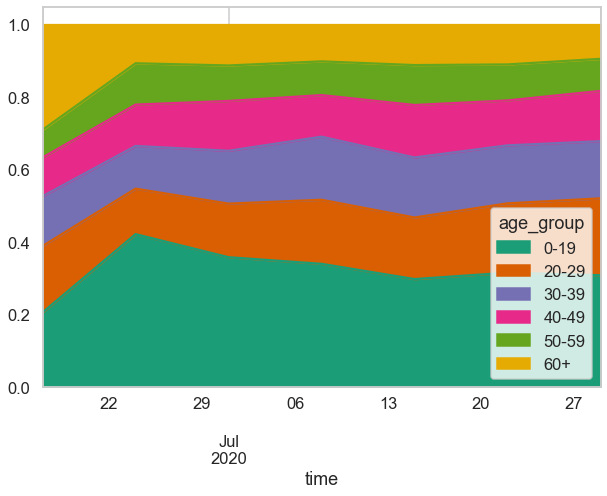

In [188]:
sns.set_style('whitegrid')
sns.set_context('talk')
rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [189]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='data', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

,first_week_day,last_week_day,age_group,gender,weekly_tests_num,weekly_newly_tested,weekly_cases,weekly_deceased
0,2020-03-15,2020-03-21,0-19,לא ידוע,44.0,44.0,0.0,0.0
1,2020-03-15,2020-03-21,0-19,זכר,1099.0,1048.0,38.0,0.0
2,2020-03-15,2020-03-21,0-19,נקבה,920.0,883.0,41.0,0.0
3,2020-03-15,2020-03-21,20-24,נקבה,639.0,618.0,37.0,0.0
4,2020-03-15,2020-03-21,20-24,לא ידוע,<15,<15,0.0,0.0


In [190]:
ag.weekly_deceased.value_counts()

0.0     777
<15     158
15.0      3
19.0      2
26.0      2
21.0      1
23.0      1
28.0      1
Name: weekly_deceased, dtype: int64

In [191]:
ag.weekly_deceased.replace('<15','10').astype(int).plot()

ValueError: invalid literal for int() with base 10: '0.0'